<a href="https://colab.research.google.com/github/alecbidaran/Simple-deep-learning-projects/blob/main/Human_action_recognition_BioSensors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling3D, Activation, UpSampling2D, BatchNormalization, add, concatenate, Lambda, Flatten, Conv2DTranspose,DepthwiseConv2D,ConvLSTM2D,TimeDistributed,Dropout
from tensorflow.keras.optimizers import RMSprop,Adam
import tensorflow.keras as keras 
import tensorflow as tf
import numpy as np 
import cv2 
import os 
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [ ]:
!git clone https://github.com/bartkowiaktomasz/har-wisdm-lstm-rnns.git

Cloning into 'har-wisdm-lstm-rnns'...
remote: Enumerating objects: 84, done.
remote: Total 84 (delta 0), reused 0 (delta 0), pack-reused 84
Unpacking objects: 100% (84/84), done.


In [ ]:
import pandas as pd 
from scipy.io import arff

In [ ]:
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]
LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]
dataset=pd.read_csv("/content/har-wisdm-lstm-rnns/data/WISDM_ar_v1.1_raw.txt",header=None,names=COLUMN_NAMES )


In [ ]:
dataset['z-axis'].replace(to_replace=r';',value=r'',regex=True,inplace=True)
dataset['z-axis'] = dataset['z-axis'].astype('float')
dataset.dropna(axis=0, how='any', inplace=True)
dataset.sample(100)

,user,activity,timestamp,x-axis,y-axis,z-axis
206765,27,Walking,11299142285000,17.31,-2.64,6.660350
678059,4,Walking,2764422343000,1.65,9.66,0.890000
792799,31,Walking,22621002052000,-3.41,6.17,1.230000
401666,10,Walking,3439442333000,11.22,18.28,12.340000
638092,12,Jogging,18357351662000,2.30,-4.48,-8.770000
...,...,...,...,...,...,...
1097930,19,Sitting,131609891511000,8.73,-0.99,1.880000
465724,33,Sitting,679612315000,5.75,2.60,7.780000
343488,11,Walking,1870752269000,4.40,8.54,6.129157
289938,32,Jogging,23878912215000,-13.21,19.38,-4.794363


In [ ]:
dataset[['timestamp','x-axis','y-axis','z-axis']]

,timestamp,x-axis,y-axis,z-axis
0,49105962326000,-0.694638,12.680544,0.503953
1,49106062271000,5.012288,11.264028,0.953424
2,49106112167000,4.903325,10.882658,-0.081722
3,49106222305000,-0.612916,18.496431,3.023717
4,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...
1098199,131623331483000,9.000000,-1.570000,1.690000
1098200,131623371431000,9.040000,-1.460000,1.730000
1098201,131623411592000,9.080000,-1.380000,1.690000
1098202,131623491487000,9.000000,-1.460000,1.730000


In [ ]:
import matplotlib.pyplot as plt


Text(0, 0.5, 'Actions')

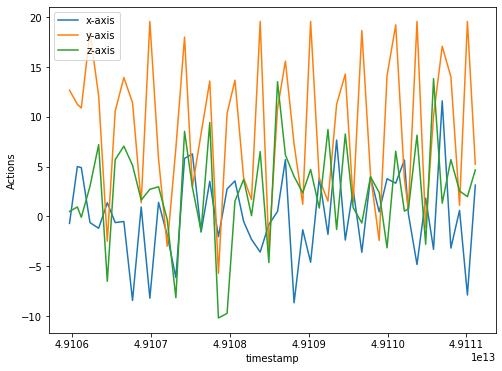

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(dataset['timestamp'][:50],dataset['x-axis'][:50],label='x-axis')
plt.plot(dataset['timestamp'][:50],dataset['y-axis'][:50],label='y-axis')
plt.plot(dataset['timestamp'][:50],dataset['z-axis'][:50],label='z-axis')
plt.legend()
plt.xlabel("timestamp")
plt.ylabel("Actions")


In [ ]:
enc = LabelEncoder()
labeled=enc.fit_transform(dataset.loc[:,('activity')].ravel())
dataset['labeled_activites']=labeled

In [ ]:
train=dataset[dataset['user']<=28]
test=dataset[dataset['user']>28]
train

,user,activity,timestamp,x-axis,y-axis,z-axis,labeled_activites
8489,17,Walking,57869902574000,0.572055,9.806650,-0.531194,5
8490,17,Walking,57870012316000,-0.000000,10.188020,-0.572055,5
8491,17,Walking,57870122301000,-0.231546,9.847511,-0.694638,5
8492,17,Walking,57870222246000,0.149824,10.079058,-0.503953,5
8493,17,Walking,57870332292000,0.149824,10.147159,-0.612916,5
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,2
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,2
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,2
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,2


In [ ]:
train['x-axis']=train['x-axis']/train['x-axis'].max()
train['y-axis']=train['y-axis']/train['y-axis'].max()
train['z-axis']=dataset['z-axis']/train['z-axis'].max()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
def sliding_window(dataframe,time_steps,step):
  xs=[]
  ys=[]
  for i in range(0,len(dataframe)-time_steps,step):
    xi=dataframe['x-axis'].values[i:i+time_steps]
    y1=dataframe['y-axis'].values[i:i+time_steps]
    z1=dataframe['z-axis'].values[i:i+time_steps]
    yi=stats.mode(dataframe['labeled_activites'][i:i+time_steps])[0][0]
    xs.append([xi,y1,z1])
    ys.append(yi)
  return np.asarray(xs),np.asarray(ys)

In [ ]:
x_train,y_train=sliding_window(train,90,50)
x_test,y_test=sliding_window(test,90,50)


In [ ]:
Y_train=keras.utils.to_categorical(y_train,num_classes=6)
Y_test=keras.utils.to_categorical(y_test,num_classes=6)

In [ ]:
print(x_train.shape)
print(y_train.shape)

(16694, 3, 90)
(16694,)


In [ ]:
print(Y_train.shape)
print(Y_test.shape)

(16694, 6)
(5267, 6)


In [ ]:
print(Y_train)
print(Y_test)

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [ ]:
x_train=x_train.reshape(-1,90,3).astype(np.float32)
x_test=x_test.reshape(-1,90,3).astype(np.float32)

In [ ]:
def create_model():
  model=keras.models.Sequential([keras.layers.Input(shape=(x_train.shape[1],x_train.shape[2])),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Conv1D(60,kernel_size=6,strides=1,padding="same",win),
                                keras.layers.MaxPool1D(pool_size=21,strides=2),
                                 keras.layers.Conv1D(60,kernel_size=6,strides=1,padding="same"),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(1000,activation='tanh'),
                                keras.layers.Dropout(0.5),

                                 keras.layers.Dense(6,activation='softmax')
                               ])
  return model

In [ ]:
disturbution=tf.distribute.experimental.CentralStorageStrategy()
with disturbution.scope():
  model=create_model()
  model.summary()
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  

INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ['/job:localhost/replica:0/task:0/device:GPU:0'], variable_device = '/job:localhost/replica:0/task:0/device:GPU:0'
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_8 (Batch (None, 90, 3)             12        
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 90, 60)            1140      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 35, 60)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 35, 60)            21660     
_________________________________________________________________
flatten_8 (Flatten)          (None, 2100)              0         
_______________

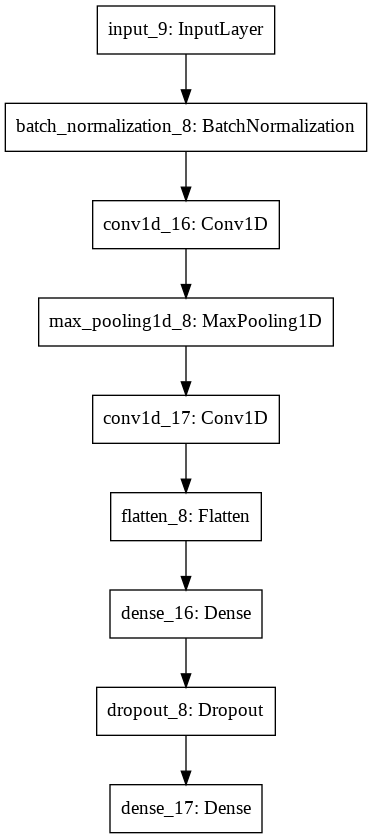

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
checkpoint=keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
early_stopping=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=1, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

reduce_LOP=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.01, cooldown=0, min_lr=0.001)
Callbacks=[checkpoint,reduce_LOP]


In [ ]:
history=model.fit(x_train,Y_train,batch_size=16,epochs=20,verbose=1)

Epoch 1/20
1044/1044 [==============================] - 4s 4ms/step - accuracy: 0.8435 - loss: 0.4875
Epoch 2/20
1044/1044 [==============================] - 4s 4ms/step - accuracy: 0.9073 - loss: 0.2911
Epoch 3/20
1044/1044 [==============================] - 4s 4ms/step - accuracy: 0.9143 - loss: 0.2736
Epoch 4/20
1044/1044 [==============================] - 4s 4ms/step - accuracy: 0.9196 - loss: 0.2560
Epoch 5/20
1044/1044 [==============================] - 4s 4ms/step - accuracy: 0.9266 - loss: 0.2404
Epoch 6/20
1044/1044 [==============================] - 4s 4ms/step - accuracy: 0.9222 - loss: 0.2476
Epoch 7/20
1044/1044 [==============================] - 4s 4ms/step - accuracy: 0.9270 - loss: 0.2448
Epoch 8/20
1044/1044 [==============================] - 4s 4ms/step - accuracy: 0.9275 - loss: 0.2503
Epoch 9/20
1044/1044 [==============================] - 4s 4ms/step - accuracy: 0.9300 - loss: 0.2322
Epoch 10/20
1044/1044 [==============================] - 4s 4ms/step - accuracy: 0

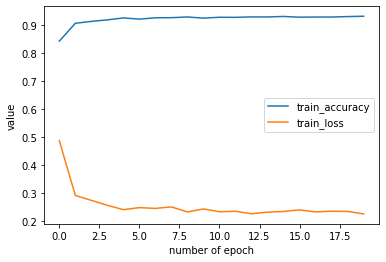

In [ ]:
plt.plot(history.history['accuracy'],label='train_accuracy')
plt.plot(history.history['loss'],label='train_loss')
plt.xlabel('number of epoch')
plt.ylabel('value')
plt.legend()

In [ ]:
best_model=keras.models.load_model('/content/drive/My Drive/nets/best_model.01-0.56.h5')

In [ ]:
best_model.evaluate(x_test,Y_test)

165/165 [==============================] - 0s 3ms/step - accuracy: 0.6628 - loss: 1.2211


[1.2210546731948853, 0.6628061532974243]

In [ ]:
pred_test=best_model.predict(x_test)
pred_test

array([[1.5709437e-01, 8.2076257e-01, 5.5079834e-09, 1.0902342e-05,
        2.0433927e-02, 1.6982624e-03],
       [3.3691175e-02, 9.6072197e-01, 1.6079849e-09, 8.9643754e-06,
        5.0238874e-03, 5.5400917e-04],
       [9.7527437e-02, 8.9057940e-01, 1.8586132e-08, 3.6703132e-05,
        9.6125491e-03, 2.2438616e-03],
       ...,
       [9.5554478e-02, 5.7949143e-05, 4.5440640e-08, 2.9414904e-03,
        4.1041267e-01, 4.9103338e-01],
       [8.4653981e-02, 2.0742540e-03, 1.6195923e-05, 3.5201281e-02,
        6.2549835e-01, 2.5255588e-01],
       [1.0877031e-01, 8.7706459e-04, 3.2362054e-06, 4.4326023e-03,
        8.2794940e-01, 5.7967335e-02]], dtype=float32)

In [ ]:
Y_test

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
y_pred_test=np.argmax(pred_test,axis=1)
print(y_pred_test)
print(y_test)

[1 1 1 ... 5 4 4]
[1 1 1 ... 3 3 3]


In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
import seaborn as sns

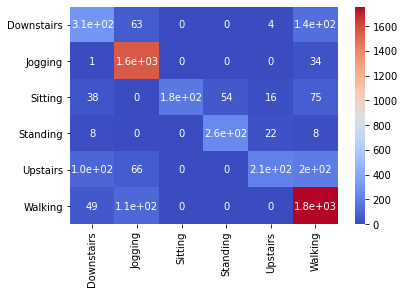

In [ ]:
confusion_matrix=metrics.confusion_matrix(y_test,y_pred_test)
sns.heatmap(confusion_matrix,cmap='coolwarm',linecolor='white',xticklabels=LABELS,yticklabels=LABELS,annot=True)

In [ ]:
print(classification_report(y_test,y_pred_test,target_names=LABELS))

              precision    recall  f1-score   support

  Downstairs       0.61      0.60      0.60       521
     Jogging       0.87      0.98      0.92      1588
     Sitting       1.00      0.49      0.66       362
    Standing       0.83      0.87      0.85       296
    Upstairs       0.84      0.37      0.51       580
     Walking       0.79      0.92      0.85      1920

    accuracy                           0.81      5267
   macro avg       0.82      0.70      0.73      5267
weighted avg       0.82      0.81      0.80      5267

